# Long

Name: Erlend Lokna, Student ID: 528564

Name: Johan Vik Mathisen, Student ID: 508258


Team name: Shaky Warriors

### Code for loading datasets

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
import seaborn as sns
import catboost as cb
from autogluon.tabular import TabularDataset, TabularPredictor
%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)


In [24]:
# from utils import get_root_dir
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
  
class DataSet:
    def __init__(self):
        """
        kind: observerd, estimated, train
        """

        train_a = pd.read_parquet('data/A/train_targets.parquet')
        train_b = pd.read_parquet('data/B/train_targets.parquet')
        train_c = pd.read_parquet('data/C/train_targets.parquet')

        # Estimated training data for each location
        X_train_estimated_a = pd.read_parquet('data/A/X_train_estimated.parquet')
        X_train_estimated_b = pd.read_parquet('data/B/X_train_estimated.parquet')
        X_train_estimated_c = pd.read_parquet('data/C/X_train_estimated.parquet')

        # Observed training data for each location
        X_train_observed_b = pd.read_parquet('data/B/X_train_observed.parquet')
        X_train_observed_a = pd.read_parquet('data/A/X_train_observed.parquet')
        X_train_observed_c = pd.read_parquet('data/C/X_train_observed.parquet')

        # Estimated test data for each location
        X_test_estimated_b = pd.read_parquet('data/B/X_test_estimated.parquet')
        X_test_estimated_a = pd.read_parquet('data/A/X_test_estimated.parquet')
        X_test_estimated_c = pd.read_parquet('data/C/X_test_estimated.parquet')

        Y_train = {
            'a': train_a, 
            'b':train_b, 
            'c':train_c
        }
        X_train_estimated = {
            'a':X_train_estimated_a,
            'b':X_train_estimated_b,
            'c':X_train_estimated_c
        }
        X_train_observed = {
            'a':X_train_observed_a,
            'b':X_train_observed_b,
            'c':X_train_observed_c
        }
        X_test_estimated = {
            'a':X_test_estimated_a,
            'b':X_test_estimated_b,
            'c':X_test_estimated_c
        }
        self.X_train_observed =  X_train_observed
        self.X_train_estimated = X_train_estimated
        self.X_test_estimated = X_test_estimated
        self.Y_train = Y_train


    def resample_to_hourly(self):
        for loc in ['a','b','c']:
            self.X_train_observed[loc] = to_hourly(self.X_train_observed[loc])
            self.X_train_estimated[loc] = to_hourly(self.X_train_estimated[loc])
            self.X_test_estimated[loc] = to_hourly(self.X_test_estimated[loc])


    def select_features(self, features):
        """ 
        Reduces dim by selecting only features from "features"
        This will remove "date_calc" from est.
        """
        for loc in ['a','b','c']:
            self.X_train_observed[loc] = self.X_train_observed[loc][features]
            self.X_train_estimated[loc] = self.X_train_estimated[loc][features]
            self.X_test_estimated[loc] = self.X_test_estimated[loc][features]

    def add_type(self):
        """
        0: Estimated data
        1: Observed data
        """
        for loc in ['a','b','c']:
            type_vec_X_tr = [1] * len(self.X_train_observed[loc])
            self.X_train_observed[loc]['type'] = type_vec_X_tr

            type_vec_X_tr_e = [0] * len(self.X_train_estimated[loc])
            self.X_train_estimated[loc]['type'] = type_vec_X_tr_e

            type_vec_X_te = [0] * len(self.X_test_estimated[loc])
            self.X_test_estimated[loc]['type'] = type_vec_X_te


    def add_location(self):
        """
        Adds a categorical feature "location" equal to the input string location.
        """
        for loc in ['a','b','c']:
            loc_vec_X_tr = [loc] * len(self.X_train_observed[loc])
            self.X_train_observed[loc]['location'] = loc_vec_X_tr

            loc_vec_X_tr_e = [loc] * len(self.X_train_estimated[loc])
            self.X_train_estimated[loc]['location'] = loc_vec_X_tr_e

            loc_vec_X_te = [loc] * len(self.X_test_estimated[loc])
            self.X_test_estimated[loc]['location'] = loc_vec_X_te


    def remove_nans(self, feature):
        for loc in ['a','b','c']:
            cols = self.X_train_observed['a'].columns
            if feature in cols:
                self.X_train_observed[loc] = self.X_train_observed[loc].dropna(subset = [feature], how = 'all')
                self.X_train_estimated[loc] = self.X_train_estimated[loc].dropna(subset = [feature], how = 'all')
                self.X_test_estimated[loc] = self.X_test_estimated[loc].dropna(subset = [feature], how = 'all')
            else:
                print("Feature not in data frame.")

    def combine_obs_est(self):
        """
        Concatinates the estimated and observed data. 
        Removes data_calc from est.
        """

        obs_a = self.X_train_observed['a']
        est_a = self.X_train_estimated['a']

        obs_b = self.X_train_observed['b']
        est_b = self.X_train_estimated['b']

        obs_c = self.X_train_observed['c']
        est_c = self.X_train_estimated['c']

        self.X_train = {
        'a':pd.concat([obs_a, est_a]),
        'b':pd.concat([obs_b, est_b]),
        'c':pd.concat([obs_c, est_c])
        }

        self.X_train['a'] = self.X_train['a'].reset_index(drop=True)
        self.X_train['b'] = self.X_train['b'].reset_index(drop=True)
        self.X_train['c'] = self.X_train['c'].reset_index(drop=True)

        self.X_train['a'], self.Y_train['a'] = match_X_Y(self.X_train['a'], self.Y_train['a'])
        self.X_train['b'], self.Y_train['b'] = match_X_Y(self.X_train['b'], self.Y_train['b'])
        self.X_train['c'], self.Y_train['c'] = match_X_Y(self.X_train['c'], self.Y_train['c'])
    
    def local_train_test(self, y_scale = False, k_b = 5, k_c = 6):

        """
        Vanilla split for local testing.
        """
        X_a = self.X_train['a']
        X_b = self.X_train['b']
        X_c = self.X_train['c']

        if y_scale:
            y_a = self.Y_train['a']
            y_b = self.Y_train['b']* k_b
            y_c = self.Y_train['c']* k_c
        else:    
            y_a = self.Y_train['a']
            y_b = self.Y_train['b']
            y_c = self.Y_train['c']

        X_train_a , X_test_a, y_train_a, y_test_a = train_test_split(X_a, y_a, test_size=2160, shuffle=False)
        X_train_b , X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=2160, shuffle=False)
        X_train_c , X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=2160, shuffle=False)
        X_train = pd.concat([X_train_a,X_train_b, X_train_c])
        X_test = pd.concat([X_test_a,X_test_b,X_test_c])

        y_train = pd.concat([y_train_a, y_train_b, y_train_c])
        y_train = y_train.reset_index(drop=True)

        y_test = pd.concat([y_test_a, y_test_b, y_test_c])
        y_test = y_test.reset_index(drop=True)

        return X_train, X_test, y_train, y_test

    def train_test(self):
        """
        Vanilla split. 
        """
        X_a = self.X_train['a']
        X_b = self.X_train['b']
        X_c = self.X_train['c']

        y_a = self.Y_train['a']
        y_b = self.Y_train['b']
        y_c = self.Y_train['c']

        y_train = pd.concat([y_a, y_b, y_c])
        y_train = y_train.reset_index(drop=True)

        X_train = pd.concat([X_a, X_b, X_c])
        X_test = pd.concat([self.X_test_estimated['a'], self.X_test_estimated['b'],self.X_test_estimated['c']])
        
        return X_train, X_test, y_train

    def scale_y_train(self, k_b = 5, k_c = 6):

        self.Y_train['b'] = self.Y_train['b'] * k_b 
        self.Y_train['c'] = self.Y_train['c'] * k_c

    def drop_bad_data(self):
        for loc in ['a', 'b', 'c']:
            y_ind = get_constant_indices(self.Y_train[loc])
            self.Y_train[loc].drop(y_ind, errors='ignore')
            self.X_train[loc].drop(y_ind, errors='ignore')


    def cyclic_time_encoding(self):
        for loc in ['a', 'b', 'c']:
            for time_feature in ["time", "date_forecast"]:
                if time_feature in self.X_train[loc].columns:
                    self.X_train[loc]['sin_hour'] = np.sin(2*np.pi*self.X_train[loc][time_feature].dt.hour/24)
                    self.X_train[loc]['sin_month'] = np.sin(2*np.pi*self.X_train[loc][time_feature].dt.month/12)

                    self.X_train[loc]['cos_hour'] = np.cos(2*np.pi*self.X_train[loc][time_feature].dt.hour/24)
                    self.X_train[loc]['cos_month'] = np.cos(2*np.pi*self.X_train[loc][time_feature].dt.month/12)
                if time_feature in self.X_test_estimated[loc].columns:    
                    self.X_test_estimated[loc]['sin_hour'] = np.sin(2*np.pi*self.X_test_estimated[loc][time_feature].dt.hour/24)
                    self.X_test_estimated[loc]['sin_month'] = np.sin(2*np.pi*self.X_test_estimated[loc][time_feature].dt.month/12)

                    self.X_test_estimated[loc]['cos_hour'] = np.cos(2*np.pi*self.X_test_estimated[loc][time_feature].dt.hour/24)
                    self.X_test_estimated[loc]['cos_month'] = np.cos(2*np.pi*self.X_test_estimated[loc][time_feature].dt.month/12)

#Helper functions

def match_X_Y(X,Y):
    """ 
    date_forecast and time must be unique!
    Matches the timestamps of X to the timestamps of Y. 
    Makes sure that the length of X and Y are equal.
    """
    Y = Y.dropna()
    X = X.rename(columns={'date_forecast': 'time'})
    merge_df = Y.merge(X, on="time", how='inner')
    Y = merge_df['pv_measurement']
    X = merge_df.drop(columns = ['pv_measurement'])
    return X,Y

def to_hourly(df):
    df['date_forecast']
    df.set_index('date_forecast', inplace=True)
    df = df.resample('H').mean()
    df.reset_index(inplace=True)
    return df

def make_categorical(data, feature_list):
    for feature in feature_list:
        data[feature] = data[feature].astype('category')


def ReLU(x):
    return x * (x > 0)

def remap(x):
    if x<0.5:
        return 0
    else:
        return 1

def pred_to_delivery(preds, filename):
    data = {'prediction':preds}
    sub = pd.DataFrame(data = data)
    sub = sub.reset_index()
    sub = sub.rename(columns={'index': 'id'})
    sub.to_csv(filename, index=False)

def get_constant_indices(ser):
    mask = (ser != 0)
    constant_periods = ser[mask].groupby((ser[mask] != ser[mask].shift()).cumsum()).cumcount().add(1)
    
    drop_mask = constant_periods >= 12
    return constant_periods[drop_mask].index

# Visualizing and examining the data

We began by reading the documentation for the dataset and looking at some plots of the data.

Plotting the power production (Y) of each office building. Similar trends, but different scales. Also observe that the data is messy/incomplete. 

<Axes: title={'center': 'Train target C'}, xlabel='time'>

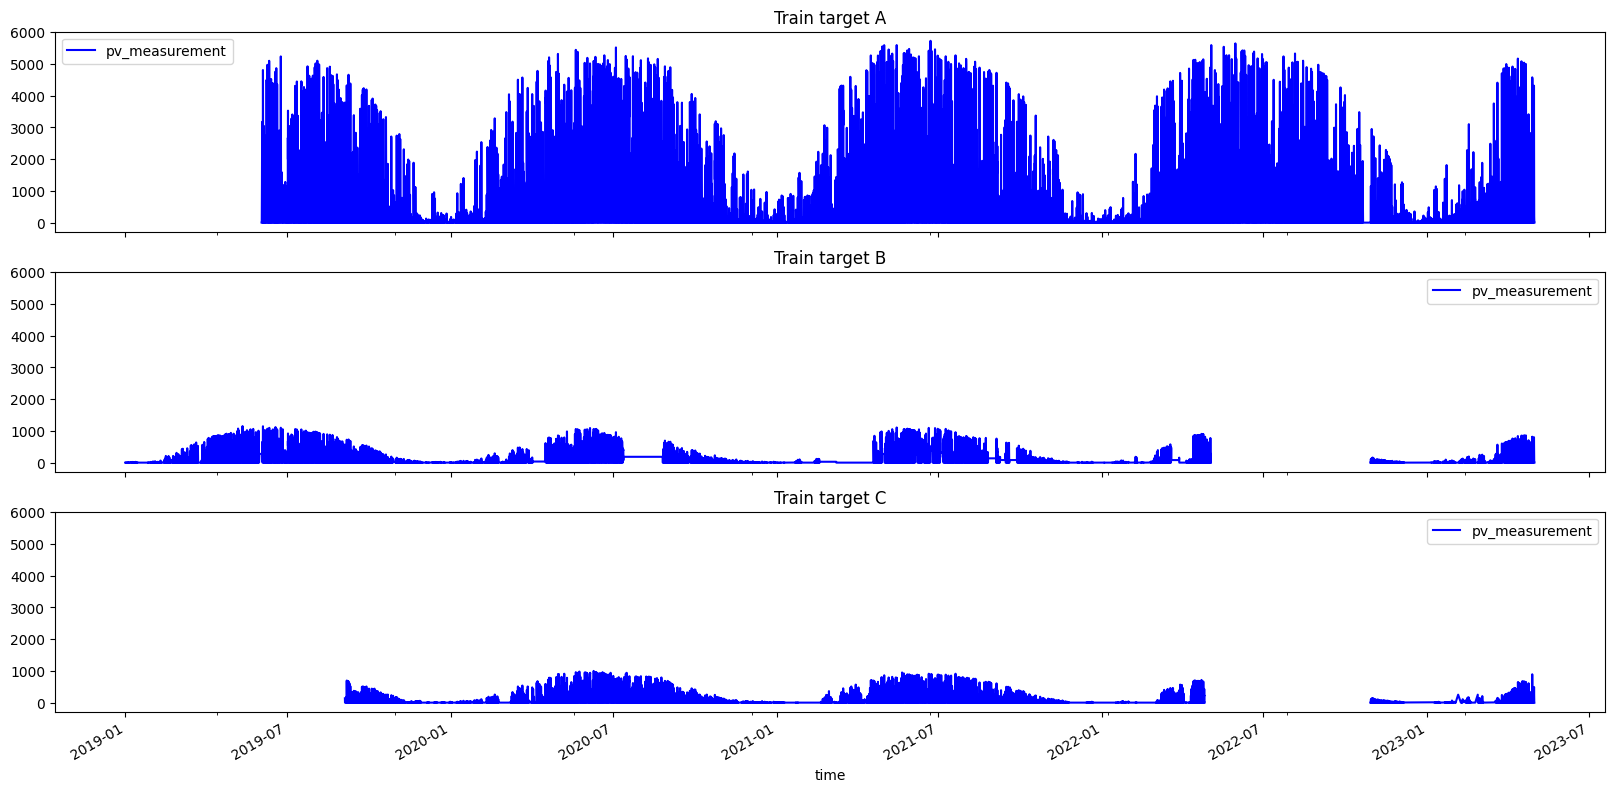

In [6]:
# Power production plots

data = DataSet()
fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True, sharey=True)
data.Y_train['a'].set_index('time').plot(ax=axs[0], title='Train target A', color='blue')
data.Y_train['b'].set_index('time').plot(ax=axs[1], title='Train target B', color='blue')
data.Y_train['c'].set_index('time').plot(ax=axs[2], title='Train target C', color='blue')


Investigating missing values in the datasets.

We see that `ceiling_height_agl:m`, `cloud_base_agl:m` and `snow_density:kgm3` has a lot of NaNs and are the only columns with NaNs. We drop these in the future.

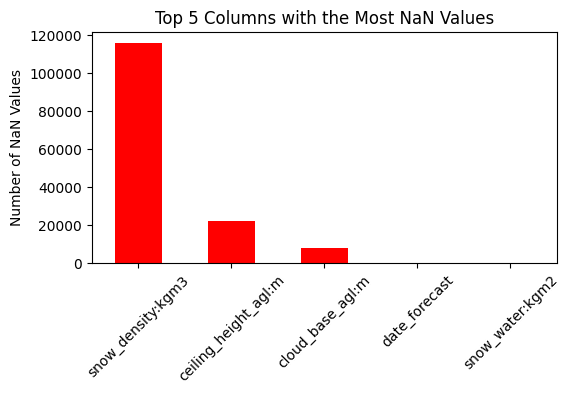

In [36]:

nan_count = data_collection.X_train_observed['a'].isnull().sum()
sorted_nan_count = nan_count.sort_values(ascending=False)
N = 5  # Change this to the number of columns you want to plot
columns_to_plot = sorted_nan_count.head(N)
plt.figure(figsize=(6, 3))
columns_to_plot.plot(kind='bar', color='red')
plt.title(f'Top {N} Columns with the Most NaN Values')
plt.ylabel('Number of NaN Values')
plt.xticks(rotation=45)
plt.show()

In [37]:
data.X_test_estimated['a']['date_forecast'].isna().sum()

0

Examining `direct_rad:W` below. Looked at all the others elsewhere, not included for readablility.

<Axes: title={'center': 'Train/Test  C'}, xlabel='date_forecast'>

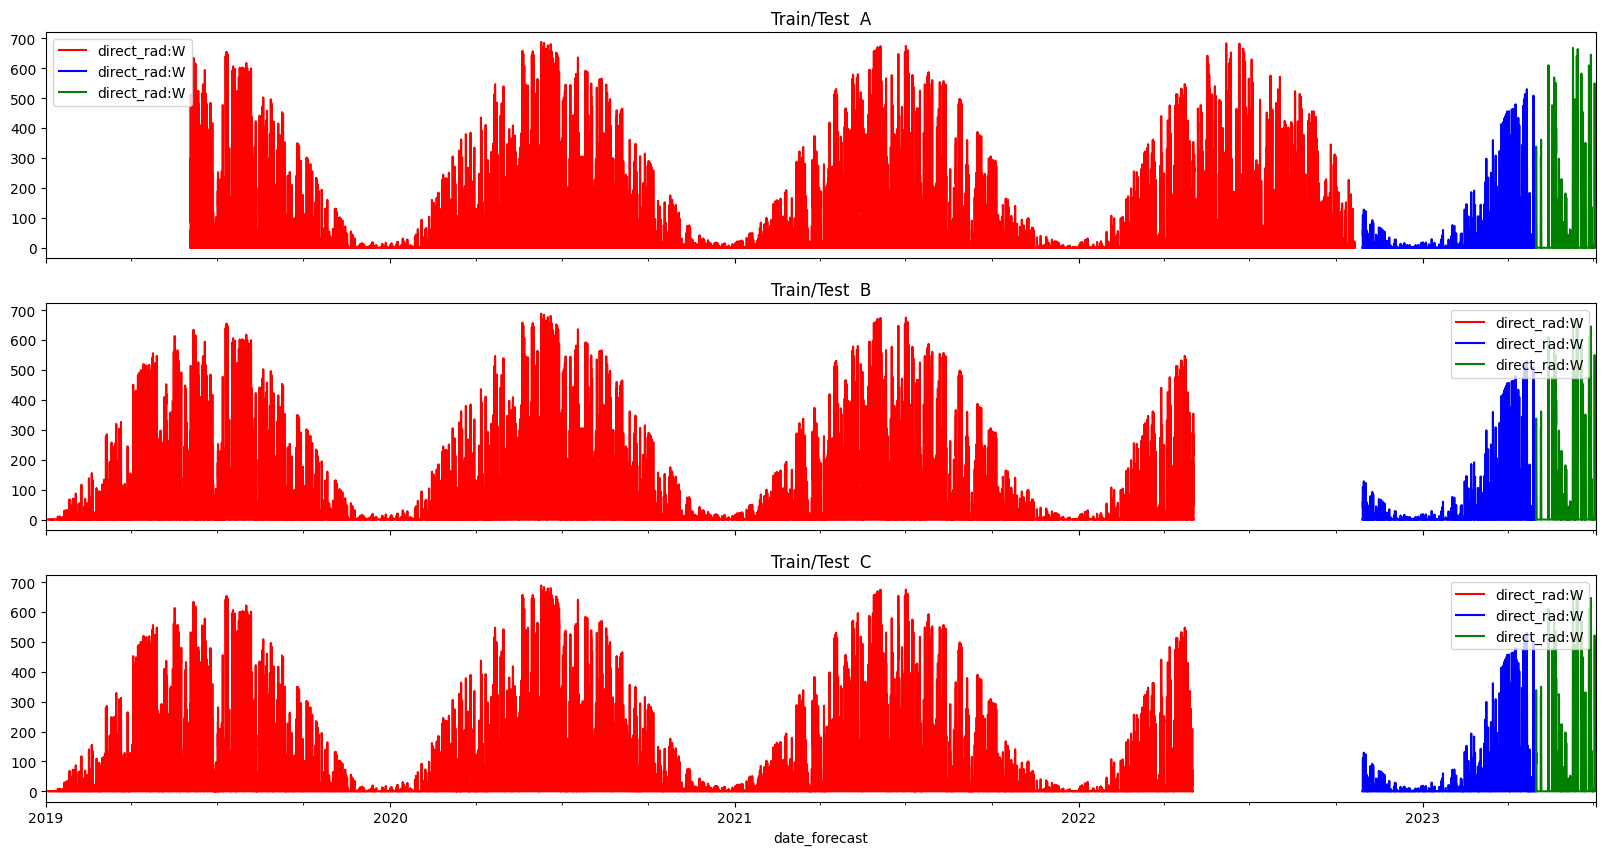

In [23]:
# Plotting a single feature
fig, axs = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
feature_name = 'direct_rad:W'
data.X_train_observed['a'][['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='red')
data.X_train_estimated['a'][['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test A', color='blue')
data.X_test_estimated['a'][['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[0], title='Train/Test  A', color='green')

data.X_train_observed['b'][['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='red')
data.X_train_estimated['b'][['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='blue')
data.X_test_estimated['b'][['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[1], title='Train/Test  B', color='green')

data.X_train_observed['c'][['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='red')
data.X_train_estimated['c'][['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='blue')
data.X_test_estimated['c'][['date_forecast', feature_name]].set_index('date_forecast').plot(ax=axs[2], title='Train/Test  C', color='green')

# Distributional differences of A, B and C

### Observed data in months of interest for prediction

The plot below shows that the difference is quite small.

<Axes: title={'center': 'Test 2023'}, xlabel='date_forecast'>

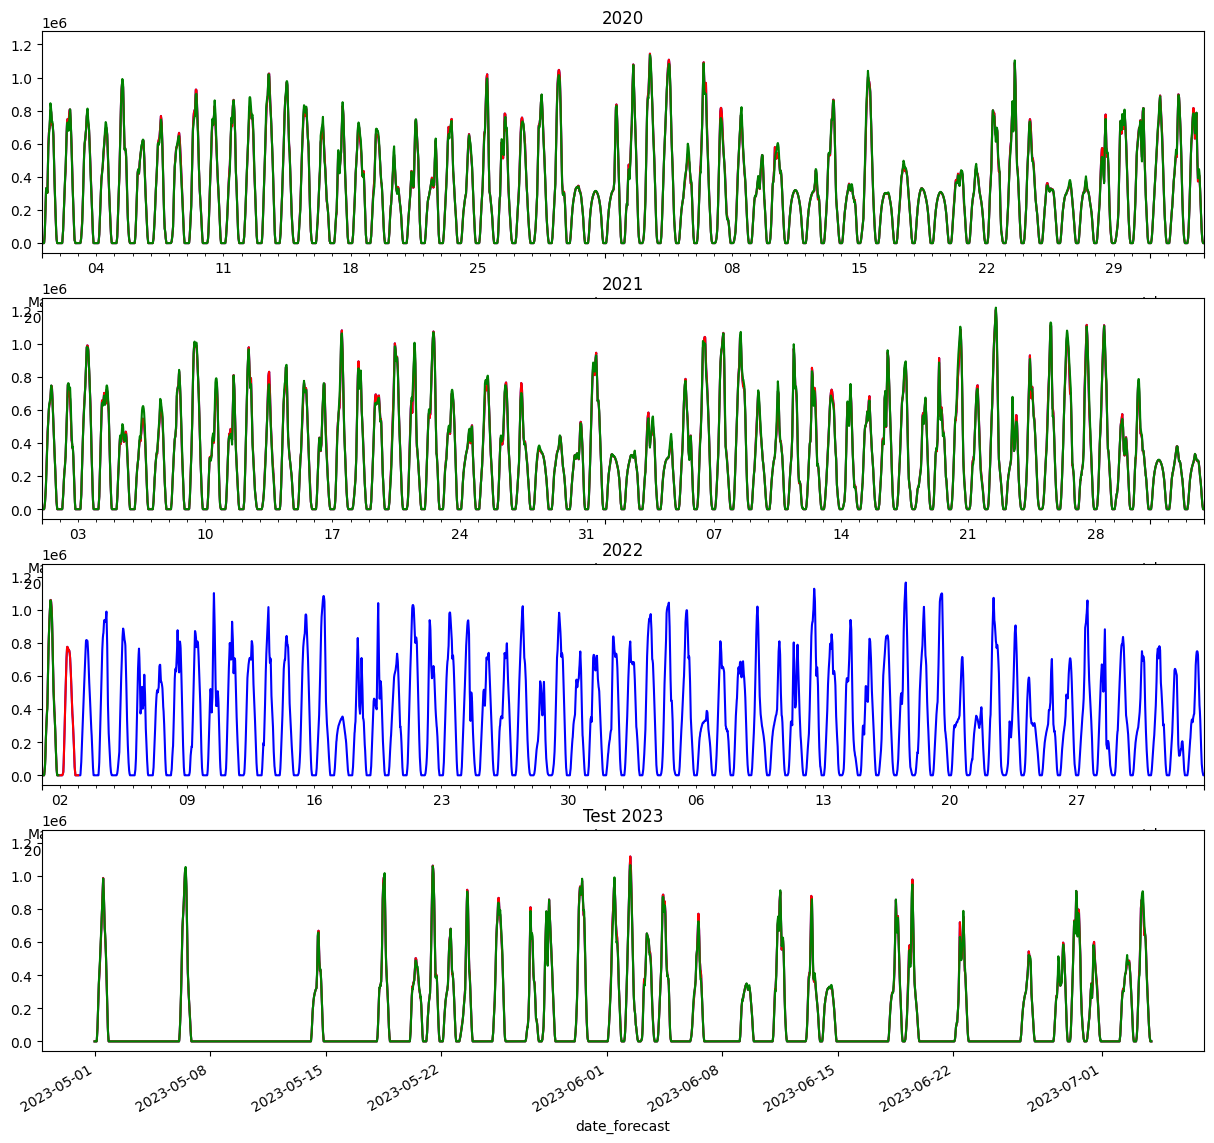

In [14]:
feature_name = 'diffuse_rad_1h:J'
fig, axs = plt.subplots(4,1,figsize = (15,15), sharey=True)
data.X_train_observed['a'].set_index('date_forecast')[feature_name]['2020-05-01':'2020-07-03'].plot(ax= axs[0], title='2020', color = 'blue')
data.X_train_observed['b'].set_index('date_forecast')[feature_name]['2020-05-01':'2020-07-03'].plot(ax= axs[0], title='2020', color ='red')
data.X_train_observed['c'].set_index('date_forecast')[feature_name]['2020-05-01':'2020-07-03'].plot(ax= axs[0], title='2020', color ='green')

data.X_train_observed['a'].set_index('date_forecast')[feature_name]['2021-05-01':'2021-07-03'].plot(ax= axs[1], title='2021', color = 'blue')
data.X_train_observed['b'].set_index('date_forecast')[feature_name]['2021-05-01':'2021-07-03'].plot(ax= axs[1], title='2021', color ='red')
data.X_train_observed['c'].set_index('date_forecast')[feature_name]['2021-05-01':'2021-07-03'].plot(ax= axs[1], title='2021', color ='green')

data.X_train_observed['a'].set_index('date_forecast')[feature_name]['2022-05-01':'2022-07-03'].plot(ax= axs[2], title='2022', color = 'blue')
data.X_train_observed['b'].set_index('date_forecast')[feature_name]['2022-05-01':'2022-07-03'].plot(ax= axs[2], title='2022', color ='red')
data.X_train_observed['c'].set_index('date_forecast')[feature_name]['2022-05-01':'2022-07-03'].plot(ax= axs[2], title='2022', color ='green')

data.X_test_estimated['a'].set_index('date_forecast')[feature_name]['2023-05-01':'2023-07-03'].plot(ax= axs[3], title='Test 2023', color = 'blue')
data.X_test_estimated['b'].set_index('date_forecast')[feature_name]['2023-05-01':'2023-07-03'].plot(ax= axs[3], title='Test 2023', color ='red')
data.X_test_estimated['c'].set_index('date_forecast')[feature_name]['2023-05-01':'2023-07-03'].plot(ax= axs[3], title='Test 2023', color ='green')


Crunching the numbers to confirm that the differences are quite small. Calculating the MAE of the features of A, B and C. 

Leaving out the columns with NaNs.

The only features with high values for the MAE has joule as unit, which is a very fine measurement unit for energy. The MAE of 21345 J is approximately 5 watt hours, which is enough enerly to power a LED light for somewhere around an hour.

We conclude that the distributional difference of the data for location A, B and C is very small. Exeptionally small between A and B.

In [18]:
data = DataSet()

categorical = ['date_forecast', 'ceiling_height_agl:m', 'cloud_base_agl:m', 'snow_density:kgm3']
features = data.X_train_observed['a'].columns
a_obs = data.X_train_observed['a'].set_index('date_forecast')['2021-05-01':'2021-07-03']
b_obs = data.X_train_observed['b'].set_index('date_forecast')['2021-05-01':'2021-07-03']
c_obs = data.X_train_observed['c'].set_index('date_forecast')['2021-05-01':'2021-07-03']
a_test = data.X_test_estimated['a'].set_index('date_forecast')
b_test = data.X_test_estimated['b'].set_index('date_forecast')
c_test = data.X_test_estimated['c'].set_index('date_forecast')
for f in features:
    if f not in categorical:
        mae_ab = mean_absolute_error(a_obs[f], b_obs[f])
        mae_ac = mean_absolute_error(a_obs[f], c_obs[f])
        mae_cb = mean_absolute_error(c_obs[f], b_obs[f])

        # if mae_ab > 0.1:
        print(f"MAE of feature {f} between a and b:{mae_ab:.4f}")
        print(f"MAE of feature {f} between a and c:{mae_ac:.4f}")
        print(f"MAE of feature {f} between c and b:{mae_cb:.4f}")
        print('----------------------------------')

MAE of feature absolute_humidity_2m:gm3 between a and b:0.0161
MAE of feature absolute_humidity_2m:gm3 between a and c:0.1720
MAE of feature absolute_humidity_2m:gm3 between c and b:0.1764
----------------------------------
MAE of feature air_density_2m:kgm3 between a and b:0.0027
MAE of feature air_density_2m:kgm3 between a and c:0.0028
MAE of feature air_density_2m:kgm3 between c and b:0.0051
----------------------------------
MAE of feature clear_sky_energy_1h:J between a and b:12.8852
MAE of feature clear_sky_energy_1h:J between a and c:863.6831
MAE of feature clear_sky_energy_1h:J between c and b:872.7941
----------------------------------
MAE of feature clear_sky_rad:W between a and b:0.0038
MAE of feature clear_sky_rad:W between a and c:0.2419
MAE of feature clear_sky_rad:W between c and b:0.2447
----------------------------------
MAE of feature dew_or_rime:idx between a and b:0.0135
MAE of feature dew_or_rime:idx between a and c:0.0425
MAE of feature dew_or_rime:idx between c a

For the min-max scaled Y values we have

In [40]:
def scale(series, feature_name):
    scaler = preprocessing.MinMaxScaler()
    series1 = pd.DataFrame({feature_name:series})
    series1[feature_name] = scaler.fit_transform(series1[[feature_name]])
    return series1

a_test = data.Y_train['a'].set_index('time')['2021-05-01':'2021-07-03']
b_test = data.Y_train['b'].set_index('time')['2021-05-01':'2021-07-03']
c_test = data.Y_train['c'].set_index('time')['2021-05-01':'2021-07-03']
mae_ab = mean_absolute_error(scale(a_test['pv_measurement'],'pv_measurement'), scale(b_test['pv_measurement'],'pv_measurement'))
mae_ac = mean_absolute_error(scale(a_test['pv_measurement'],'pv_measurement'), scale(c_test['pv_measurement'],'pv_measurement'))
mae_cb = mean_absolute_error(scale(c_test['pv_measurement'],'pv_measurement'), scale(b_test['pv_measurement'],'pv_measurement'))
print(f"MAE in scaled Y between a and b:{mae_ab:.4f}")
print(f"MAE in scaled Y between a and c:{mae_ac:.4f}")
print(f"MAE in scaled Y between c and b:{mae_cb:.4f}")
print('----------------------------------')

MAE in scaled Y between a and b:0.0477
MAE in scaled Y between a and c:0.0366
MAE in scaled Y between c and b:0.0598
----------------------------------


# Redundancies in the data.

We present some heatmaps of the correlation matrices in order to get an impression of how the covariates relate to eachother linearly.

We observe that several covariates are heavily correlated, which is not surprising as several of the covariates are the same quantity in different measurement units of over slightly different time scales.

/var/folders/tz/7b83mvms205g7153tt6m1lnr0000gn/T/ipykernel_2752/2312187350.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.X_train_observed['a'].corr().round(2)
/Users/johanvikmathisen/Desktop/Fag/Matematikk/Solar-Energy-Prediction/.venv/lib/python3.10/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


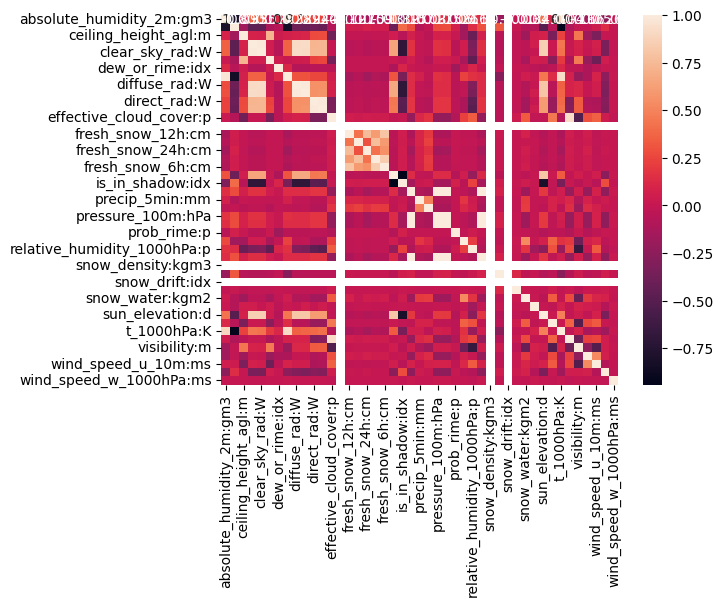

In [15]:
#correlation matrix and heatmap

corr = data.X_train_observed['a'].corr().round(2)
sns.heatmap(corr, annot=True)
plt.show()

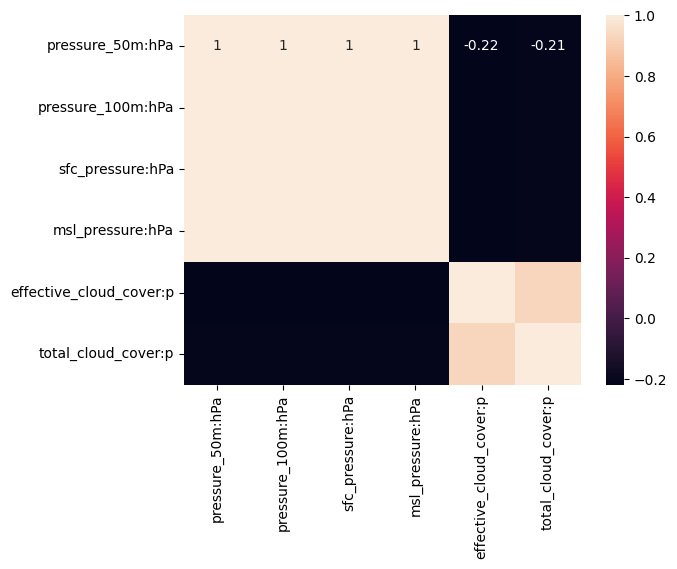

In [19]:

corr_check = data.X_train_observed['a'][['pressure_50m:hPa', 'pressure_100m:hPa','sfc_pressure:hPa','msl_pressure:hPa', 'effective_cloud_cover:p', 'total_cloud_cover:p']]

corr = corr_check.corr().round(2)
sns.heatmap(corr, annot=True)
plt.show()

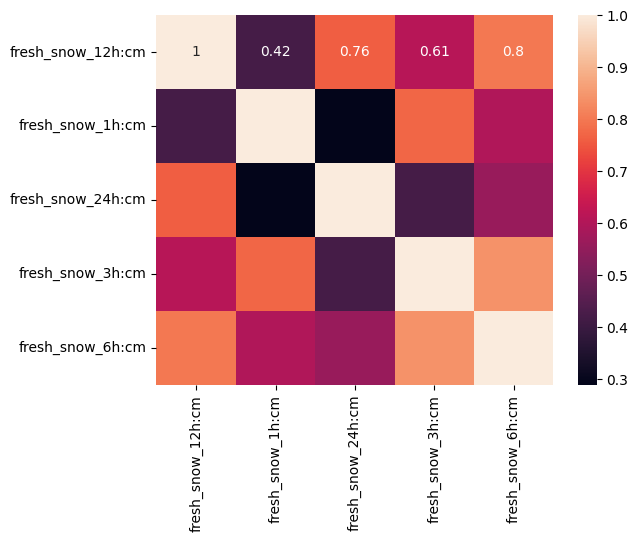

In [20]:
check_list = ['fresh_snow_12h:cm','fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm']
corr_check = data.X_train_observed['a'][check_list]

corr = corr_check.corr().round(2)
sns.heatmap(corr, annot=True)
plt.show()

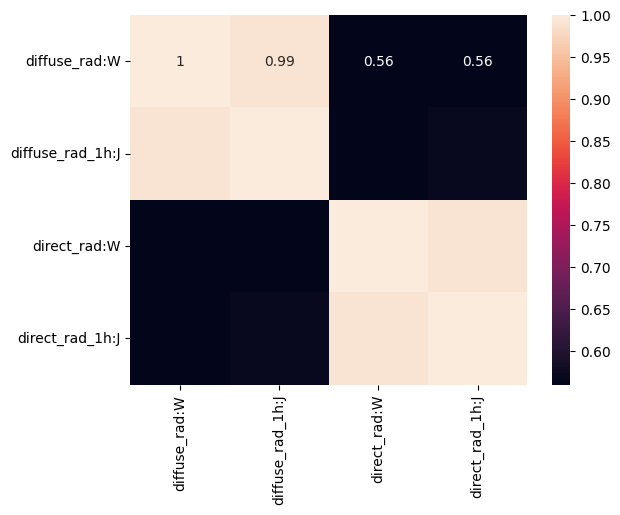

In [21]:
# check_list = ['diffuse_rad_1h:J', 'clear_sky_rad:W', 'clear_sky_energy_1h:J']
check_list = ['diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J']

corr_check = data.X_train_observed['a'][check_list]

corr = corr_check.corr().round(2)
sns.heatmap(corr, annot=True)
plt.show()

# Initial mistakes

Sorted all the combined data on time. Gave A,B,C,A,B,C.... The predictions were then evaluated against the true Y values which came in sequence A,A,A.., B,B,B...C,C,C.. This lead to stupidly bad results (800 ish).




# Model 1: Cat Boost

This has been our main model for the entire project. Almost all our experiments has been with CatBoost. Fine tuning the parameters and tweaking the data. The reason for this is that the model provided good result out of the box, and that before we were able to harness the information in the data, different models would probably not provide substatially better results. Sticking to one model for a long time made it easier to controll the experiments.

We attempted to use optuna for hyper parameter optimization. But ended up with better results by some trial and error.

### One big

This is the same model as given in the first short notebook, but the code is not as reduced.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import catboost as cb

%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

selected_features = ['date_forecast', 'absolute_humidity_2m:gm3',
       'air_density_2m:kgm3', 'clear_sky_energy_1h:J',
       'clear_sky_rad:W', 'dew_or_rime:idx',
       'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W',
       'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m',
       'fresh_snow_6h:cm', 'is_day:idx',
       'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm',
       'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_depth:cm',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
       'wind_speed_w_1000hPa:ms']

numeric_features = ['absolute_humidity_2m:gm3',
       'air_density_2m:kgm3', 'clear_sky_energy_1h:J',
       'clear_sky_rad:W',
       'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W',
       'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m',
       'fresh_snow_6h:cm', 
        'msl_pressure:hPa', 'precip_5min:mm',
       'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_depth:cm',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
       'wind_speed_w_1000hPa:ms']
made_features = ['location', 'type', 'is_day:idx', 'is_in_shadow:idx', 'dew_or_rime:idx']

drop_feature = 'diffuse_rad:W'

data_collection = DataSet()

data_collection.select_features(selected_features)
data_collection.resample_to_hourly()
data_collection.remove_nans(drop_feature)
data_collection.add_location()
data_collection.add_type()
data_collection.combine_obs_est()
data_collection.drop_bad_data()
data_collection.cyclic_time_encoding()

local_test = False
y_scale = True
normalize = False


k_b = 5
k_c = 6
if local_test:
    X_train, X_test, y_train, y_test = data_collection.local_train_test(y_scale=y_scale, k_b = k_b, k_c = k_c)

else:
    if y_scale:
        data_collection.scale_y_train()
    X_train, X_test, y_train = data_collection.train_test()


if normalize:
    scaler = preprocessing.MinMaxScaler()
    X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
    X_test[numeric_features] = scaler.fit_transform(X_test[numeric_features])

for f in made_features:
    if f not in ['location', 'type']:
        X_train[f] = X_train[f].map(remap)
        X_test[f] = X_test[f].map(remap)


make_categorical(X_train,made_features)
X_train = X_train.drop('time', axis=1)

make_categorical(X_test,made_features)
X_test = X_test.drop('date_forecast', axis=1)





In [ ]:
train_pool = cb.Pool(
    X_train,
    y_train,
    cat_features = made_features
)
if local_test:
    test_pool = cb.Pool(
        X_test,
        y_test,
        cat_features = made_features
    )
else:
    test_pool = cb.Pool(
        X_test,
        cat_features = made_features
    )

model = cb.CatBoostRegressor(
    iterations = 10000,
    depth = 9,
    learning_rate =0.005,
    loss_function ='MAE',
    cat_features = made_features
)

In [ ]:
#train the model
model.fit(train_pool, silent=True)
# make the prediction using the resulting model
preds = model.predict(test_pool)

In [ ]:
if y_scale:
    length = int((X_test.shape[0]/3))
    if local_test:
        y_test_a = y_test[:length]
        y_test_b = y_test[length:2*length] / k_b
        y_test_c = y_test[2*length:3*length] / k_c
        y_test = pd.concat([y_test_a,y_test_b, y_test_c])

    pred_a = preds[:length]
    pred_b = preds[length:2*length] / k_b
    pred_c = preds[2*length:3*length] / k_c
    preds = np.concatenate([pred_a,pred_b, pred_c])

if local_test:
    print(f'Total: MAE: {mean_absolute_error(preds, y_test)}')
    print(f'Total: MAE on ReLU of y_pred: {mean_absolute_error(ReLU(preds), y_test)}')
    print(f'Total: MAE on abs(-) of y_pred: {mean_absolute_error(np.abs(preds), y_test)}')
    if y_scale:
        print(f'A: MAE: {mean_absolute_error(pred_a, y_test_a)}')
        print(f'B: MAE: {mean_absolute_error(pred_b, y_test_b)}')
        print(f'C: MAE: {mean_absolute_error(pred_c, y_test_c)}')

preds_df = pd.DataFrame(preds)

if local_test:
    fig, axs = plt.subplots(2,1,figsize = (15,15), sharex = True, sharey=True)
    y_test.plot(ax=axs[0], title='y test', color='red')
    preds_df.plot(ax=axs[1], title='y pred', color='blue')
else:
    preds_df.plot(title='y pred', color='blue')

preds_one_big_cb = preds

### Three smaller models

In [ ]:
selected_features = ['date_forecast', 'absolute_humidity_2m:gm3',
       'air_density_2m:kgm3', 'clear_sky_energy_1h:J',
       'clear_sky_rad:W', 'dew_or_rime:idx',
       'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W',
       'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m',
       'fresh_snow_6h:cm', 'is_day:idx',
       'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm',
       'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_depth:cm',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
       'wind_speed_w_1000hPa:ms']

made_features = ['location', 'type', 'is_day:idx', 'is_in_shadow:idx', 'dew_or_rime:idx']

drop_feature = 'diffuse_rad:W'

data_collection = DataSet()
data_collection.select_features(selected_features)
data_collection.resample_to_hourly()
data_collection.remove_nans(drop_feature)
data_collection.add_location()
data_collection.add_type()
#
data_collection.combine_obs_est()
data_collection.drop_bad_data()
data_collection.cyclic_time_encoding()

local_test = False
y_scale = True
k_b = 5
k_c = 6


if y_scale:
    data_collection.scale_y_train()

for loc in ['a','b', 'c']:
    if 'is_in_shadow:idx' in made_features:
        data_collection.X_train[loc]['is_in_shadow:idx'] = data_collection.X_train[loc]['is_in_shadow:idx'].map(remap)

        data_collection.X_test_estimated[loc]['is_in_shadow:idx'] = data_collection.X_test_estimated[loc]['is_in_shadow:idx'].map(remap)

    make_categorical(data_collection.X_train[loc], made_features)
    data_collection.X_train[loc] = data_collection.X_train[loc].rename(columns={'date_forecast': 'time'})
    data_collection.X_train[loc] = data_collection.X_train[loc].reset_index(drop=True)
    data_collection.X_train[loc] = data_collection.X_train[loc].drop('time', axis=1)

    if 'date_calc' in data_collection.X_train[loc].columns:
        data_collection.X_train[loc] = data_collection.X_train[loc].drop('date_calc', axis=1)

    make_categorical(data_collection.X_test_estimated[loc], made_features)
    data_collection.X_test_estimated[loc] = data_collection.X_test_estimated[loc].rename(columns={'date_forecast': 'time'})
    data_collection.X_test_estimated[loc] = data_collection.X_test_estimated[loc].reset_index(drop=True)
    data_collection.X_test_estimated[loc] = data_collection.X_test_estimated[loc].drop('time', axis=1)

    if 'date_calc' in data_collection.X_test_estimated[loc].columns:
        data_collection.X_test_estimated[loc] = data_collection.X_test_estimated[loc].drop('date_calc', axis=1)


X_train_a = data_collection.X_train['a']
X_train_b = data_collection.X_train['b']
X_train_c = data_collection.X_train['c']

y_train_a = data_collection.Y_train['a']
y_train_b = data_collection.Y_train['b']
y_train_c = data_collection.Y_train['c']

if local_test:
        X_train_a , X_test_a, y_train_a, y_test_a = train_test_split(X_train_a, y_train_a, test_size=2160, shuffle=False)
        X_train_b , X_test_b, y_train_b, y_test_b = train_test_split(X_train_b, y_train_b, test_size=2160, shuffle=False)
        X_train_c , X_test_c, y_train_c, y_test_c = train_test_split(X_train_c, y_train_c, test_size=2160, shuffle=False)

else:
    X_test_a = data_collection.X_test_estimated['a']
    X_test_b = data_collection.X_test_estimated['b']
    X_test_c = data_collection.X_test_estimated['c']


In [ ]:
train_pool_a = cb.Pool(
    X_train_a,
    y_train_a,
    cat_features = made_features
)
train_pool_b = cb.Pool(
    X_train_b,
    y_train_b,
    cat_features = made_features
)
train_pool_c = cb.Pool(
    X_train_c,
    y_train_c,
    cat_features = made_features
)

test_pool_a = cb.Pool(
        X_test_a,
        cat_features = made_features
    )
test_pool_b = cb.Pool(
        X_test_b,
        cat_features = made_features
    )
test_pool_c = cb.Pool(
        X_test_c,
        cat_features = made_features
    )

it = 10000

model_a = cb.CatBoostRegressor(
    iterations = it,
    depth = 9,
    learning_rate =0.01,
    loss_function ='MAE',
    cat_features = made_features
)

model_b = cb.CatBoostRegressor(
    iterations = it,
    depth = 9,
    learning_rate =0.01,
    loss_function ='MAE',
    cat_features = made_features
)

model_c = cb.CatBoostRegressor(
    iterations = it,
    depth = 9,
    learning_rate =0.01,
    loss_function ='MAE',
    cat_features = made_features
)

In [ ]:
#train the model
model_a.fit(train_pool_a, silent=True)
# make the prediction using the resulting model
preds_a = model_a.predict(test_pool_a)

#train the model
model_b.fit(train_pool_b, silent=True)
# make the prediction using the resulting model
preds_b = model_b.predict(test_pool_b)

#train the model
model_c.fit(train_pool_c, silent=True)
# make the prediction using the resulting model
preds_c = model_c.predict(test_pool_c)

In [ ]:
if local_test:
    print(f'A MAE: {mean_absolute_error(preds_a, y_test_a)}')
    print(f'B MAE: {mean_absolute_error(preds_b, y_test_b)}')
    print(f'C MAE: {mean_absolute_error(preds_c, y_test_c)}')
    diff_a = np.abs(y_test_a - preds_a)
    diff_b = np.abs(y_test_b - preds_b)
    diff_c = np.abs(y_test_c - preds_c)
    y_test = pd.DataFrame({'a':y_test_a , 'b': y_test_b , 'c':y_test_c})
    diff = pd.DataFrame({'a': diff_a, 'b' : diff_b, 'c':diff_c})

preds_df = pd.DataFrame({'a': preds_a,'b' : preds_b,'c' : preds_c})

if local_test:
    fig, axs = plt.subplots(6,1,figsize = (15,15))
    y_test['a'].plot(ax=axs[0], title='y test a', color='red')
    preds_df['a'].plot(ax=axs[1], title='y pred a', color='blue')
    y_test['b'].plot(ax=axs[2], title='y test b', color='red')
    preds_df['b'].plot(ax=axs[3], title='y pred b', color='blue')
    y_test['c'].plot(ax=axs[4], title='y test c', color='red')
    preds_df['c'].plot(ax=axs[5], title='y pred c', color='blue')
else:
    fig, axs = plt.subplots(3,1,figsize = (15,15))
    preds_df['a'].plot(ax=axs[0], title='y pred a', color='blue')
    preds_df['b'].plot(ax=axs[1], title='y pred b', color='red')
    preds_df['c'].plot(ax=axs[2], title='y pred c', color='green')



In [ ]:
if local_test:
    fig, axs = plt.subplots(3,1,figsize = (15,15))
    diff['a'].plot(ax=axs[0], title='abs diff y pred a', color='blue')
    diff['b'].plot(ax=axs[1], title='abs diff y pred b', color='red')
    diff['c'].plot(ax=axs[2], title='abs diff y pred c', color='green')


### One big vs. three smaller models

We tested one big training data set with all data from A, B and C together, and then training one model, as well as three separate models, one for each location. The big model provided better results throughout, and less computation time, than the small ones. Also, when we introduced `y_scale()` to the big model was far better.


### Summer month model

As the task of this project was to predict the solar power generation in the summer months, we thought maybe that a model traine solely on these months would perform ok. Either as a single model or part of an ensamble. It did not provide any great results.

In [ ]:
def combine_obs_est_summer(data_collection):
    """
    Concatinates the estimated and observed data. 
    Removes data_calc from est.
    """

    obs_a = data_collection.X_train_observed['a']
    est_a = data_collection.X_train_estimated['a']

    obs_b = data_collection.X_train_observed['b']
    est_b = data_collection.X_train_estimated['b']

    obs_c = data_collection.X_train_observed['c']
    est_c = data_collection.X_train_estimated['c']

    data_collection.X_train = {
    'a':pd.concat([obs_a, est_a]),
    'b':pd.concat([obs_b, est_b]),
    'c':pd.concat([obs_c, est_c])
    }

    data_collection.X_train['a'] = data_collection.X_train['a'].reset_index(drop=True)
    data_collection.X_train['b'] = data_collection.X_train['b'].reset_index(drop=True)
    data_collection.X_train['c'] = data_collection.X_train['c'].reset_index(drop=True)
    
selected_features = ['date_forecast', 'absolute_humidity_2m:gm3',
       'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
       'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_or_rime:idx',
       'dew_point_2m:K', 'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W',
       'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m',
       'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
       'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'is_day:idx',
       'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm',
       'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_density:kgm3', 'snow_depth:cm',
       'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
       'wind_speed_w_1000hPa:ms']

made_features = ['location', 'type', 'is_day:idx', 'is_in_shadow:idx']

drop_feature = 'diffuse_rad:W'



#Loading all data
data_collection = DataSet()
data_collection.select_features(selected_features)
data_collection.resample_to_hourly()
data_collection.remove_nans(drop_feature)
data_collection.add_location()
data_collection.add_type()
#
data_collection.combine_obs_est()
data_collection.drop_bad_data()
data_collection.cyclic_time_encoding()

tr_19_a = data_collection.X_train['a'].set_index('date_forecast')['2019-05-01':'2019-07-03']
tr_19_b = data_collection.X_train['b'].set_index('date_forecast')['2019-05-01':'2019-07-03']
tr_19_c = data_collection.X_train['c'].set_index('date_forecast')['2019-05-01':'2019-07-03']
tr_20_a = data_collection.X_train['a'].set_index('date_forecast')['2020-05-01':'2020-07-03']
tr_20_b = data_collection.X_train['b'].set_index('date_forecast')['2020-05-01':'2020-07-03']
tr_20_c = data_collection.X_train['c'].set_index('date_forecast')['2020-05-01':'2020-07-03']
tr_21_a = data_collection.X_train['a'].set_index('date_forecast')['2021-05-01':'2021-07-03']
tr_21_b = data_collection.X_train['b'].set_index('date_forecast')['2021-05-01':'2021-07-03']
tr_21_c = data_collection.X_train['c'].set_index('date_forecast')['2021-05-01':'2021-07-03']
tr_22_a = data_collection.X_train['a'].set_index('date_forecast')['2022-05-01':'2022-07-03']
tr_22_b = data_collection.X_train['b'].set_index('date_forecast')['2022-05-01':'2022-07-03']
tr_22_c = data_collection.X_train['c'].set_index('date_forecast')['2022-05-01':'2022-07-03']


Y_tr_19_a = data_collection.Y_train['a'].set_index('time')['2019-05-01':'2019-07-03']
Y_tr_19_b = data_collection.Y_train['b'].set_index('time')['2019-05-01':'2019-07-03']
Y_tr_19_c = data_collection.Y_train['c'].set_index('time')['2019-05-01':'2019-07-03']
Y_tr_20_a = data_collection.Y_train['a'].set_index('time')['2020-05-01':'2020-07-03']  
Y_tr_20_b = data_collection.Y_train['b'].set_index('time')['2020-05-01':'2020-07-03']
Y_tr_20_c = data_collection.Y_train['c'].set_index('time')['2020-05-01':'2020-07-03']
Y_tr_21_a = data_collection.Y_train['a'].set_index('time')['2021-05-01':'2021-07-03']  
Y_tr_21_b = data_collection.Y_train['b'].set_index('time')['2021-05-01':'2021-07-03']
Y_tr_21_c = data_collection.Y_train['c'].set_index('time')['2021-05-01':'2021-07-03']
Y_tr_22_a = data_collection.Y_train['a'].set_index('time')['2022-05-01':'2022-07-03']  
Y_tr_22_b = data_collection.Y_train['b'].set_index('time')['2022-05-01':'2022-07-03']
Y_tr_22_c = data_collection.Y_train['c'].set_index('time')['2022-05-01':'2022-07-03']


tr_19_a = tr_19_a.reset_index(drop=False)
tr_19_b = tr_19_b.reset_index(drop=False)
tr_19_c = tr_19_c.reset_index(drop=False)
tr_20_a = tr_20_a.reset_index(drop=False)
tr_20_b = tr_20_b.reset_index(drop=False)
tr_20_c = tr_20_c.reset_index(drop=False)
tr_21_a = tr_21_a.reset_index(drop=False)
tr_21_b = tr_21_b.reset_index(drop=False)
tr_21_c = tr_21_c.reset_index(drop=False)
tr_22_a = tr_22_a.reset_index(drop=False)
tr_22_b = tr_22_b.reset_index(drop=False)
tr_22_c = tr_22_c.reset_index(drop=False)

Y_tr_19_a = Y_tr_19_a.reset_index(drop=False)
Y_tr_19_b = Y_tr_19_b.reset_index(drop=False)
Y_tr_19_c = Y_tr_19_c.reset_index(drop=False)
Y_tr_20_a = Y_tr_20_a.reset_index(drop=False)
Y_tr_20_b = Y_tr_20_b.reset_index(drop=False)
Y_tr_20_c = Y_tr_20_c.reset_index(drop=False)
Y_tr_21_a = Y_tr_21_a.reset_index(drop=False)
Y_tr_21_b = Y_tr_21_b.reset_index(drop=False)
Y_tr_21_c = Y_tr_21_c.reset_index(drop=False)
Y_tr_22_a = Y_tr_22_a.reset_index(drop=False)
Y_tr_22_b = Y_tr_22_b.reset_index(drop=False)
Y_tr_22_c = Y_tr_22_c.reset_index(drop=False)


X_train_summer_a = pd.concat([tr_19_a, tr_20_a, tr_21_a, tr_22_a])
X_train_summer_b = pd.concat([tr_19_b, tr_20_b, tr_21_b, tr_22_b])
X_train_summer_c = pd.concat([tr_19_c, tr_20_c, tr_21_c, tr_22_c])



Y_train_summer_a = pd.concat([Y_tr_19_a, Y_tr_20_a, Y_tr_21_a, Y_tr_22_a])
Y_train_summer_b = pd.concat([Y_tr_19_b, Y_tr_20_b, Y_tr_21_b, Y_tr_22_b])
Y_train_summer_c = pd.concat([Y_tr_19_c, Y_tr_20_c, Y_tr_21_c, Y_tr_22_c])



X_train_summer_a, Y_train_summer_a = match_X_Y(X_train_summer_a, Y_train_summer_a)
X_train_summer_b, Y_train_summer_b = match_X_Y(X_train_summer_b, Y_train_summer_b)
X_train_summer_c, Y_train_summer_c = match_X_Y(X_train_summer_c, Y_train_summer_c)

k_b = 5
k_c = 6

Y_train_summer_b = Y_train_summer_b * k_b 
Y_train_summer_c = Y_train_summer_c * k_c
X_train = pd.concat([X_train_summer_a,X_train_summer_b,X_train_summer_c])
y_train = pd.concat([Y_train_summer_a,Y_train_summer_b,Y_train_summer_c])

X_test = pd.concat([data_collection.X_test_estimated['a'], data_collection.X_test_estimated['b'],data_collection.X_test_estimated['c']])

for f in made_features:
    if f not in ['location', 'type']:
        X_train[f] = X_train[f].map(remap)
        X_test[f] = X_test[f].map(remap)


make_categorical(X_train,made_features)
X_train = X_train.drop('time', axis=1)

make_categorical(X_test,made_features)
X_test = X_test.drop('date_forecast', axis=1)


In [ ]:
train_pool = cb.Pool(
    X_train,
    y_train,
    cat_features = made_features
)

test_pool = cb.Pool(
    X_test,
    cat_features = made_features
)

model = cb.CatBoostRegressor(
    iterations = 10000,
    depth = 9,
    learning_rate =0.005,
    loss_function ='MAE',
    cat_features = made_features
)

In [ ]:
#train the model
model.fit(train_pool, silent=True)
# make the prediction using the resulting model
preds = model.predict(test_pool)

In [ ]:
#scale back

length = int((X_test.shape[0]/3))

pred_a = preds[:length]
pred_b = preds[length:2*length] / k_b
pred_c = preds[2*length:3*length] / k_c
preds = np.concatenate([pred_a,pred_b, pred_c])


preds_df = pd.DataFrame(preds)


preds_df.plot(title='y pred', color='blue')



# Model 2: AutoGluon

Our best model on terms of Kaggle score was an ensamble model using AutoGluon and our top performing CatBoost model. There has been a lot of issues regarding reproducability of the Autogluon model.  

In [ ]:
selected_features = ['date_forecast', 'absolute_humidity_2m:gm3',
       'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms']

made_features = ['location', 'type', 'is_day:idx', 'is_in_shadow:idx', 'dew_or_rime:idx']

drop_feature = 'diffuse_rad:W'

data_collection = DataSet()
data_collection.select_features(selected_features)
data_collection.resample_to_hourly()
data_collection.remove_nans(drop_feature)
data_collection.add_location()
data_collection.add_type()

data_collection.combine_obs_est()
data_collection.drop_bad_data()
data_collection.cyclic_time_encoding()

X_a = data_collection.X_train['a']
X_b = data_collection.X_train['b']
X_c = data_collection.X_train['c']

y_a = data_collection.Y_train['a']
y_b = data_collection.Y_train['b']
y_c = data_collection.Y_train['c']

make_categorical(X_a,made_features)
make_categorical(X_b,made_features)
make_categorical(X_c,made_features)


drop_cols = ['location', 'time']

df_a = pd.concat([X_a, y_a], axis=1).drop(columns=drop_cols)
df_b = pd.concat([X_b, y_b], axis=1).drop(columns=drop_cols)
df_c = pd.concat([X_c, y_c], axis=1).drop(columns=drop_cols)

seed = 246
data = dict()
# sample 50% of the data for each building with type = 0 (estimated)
df_a_tune = df_a[df_a['type'] == 0].sample(frac=0.5, random_state=seed)
df_b_tune = df_b[df_b['type'] == 0].sample(frac=0.5, random_state=seed)   
df_c_tune = df_c[df_c['type'] == 0].sample(frac=0.5, random_state=seed)

# drop these rows from the original data
df_a_train = df_a.drop(df_a_tune.index)
df_b_train = df_b.drop(df_b_tune.index)
df_c_train = df_c.drop(df_c_tune.index)

data['a'] = [df_a_train, df_a_tune]
data['b'] = [df_b_train, df_b_tune]
data['c'] = [df_c_train, df_c_tune]

#### Models

In [ ]:

#3 hours (per model)
time_in_sek = 60*60*2

label = 'pv_measurement'

In [ ]:

predictor_a = TabularPredictor(label=label, eval_metric='mae').fit(
    train_data = data['a'][0], 
    time_limit = time_in_sek,
    presets='best_quality',
    num_bag_folds=8,
    num_stack_levels=0,
    tuning_data = data['a'][1],
    use_bag_holdout= True
)

In [ ]:
predictor_b = TabularPredictor(label=label, eval_metric='mae').fit(
    train_data = data['b'][0], 
    time_limit = time_in_sek,
    presets='best_quality',
    num_bag_folds=8,
    num_stack_levels=0,
    tuning_data = data['b'][1],
    use_bag_holdout=True
)


In [ ]:

predictor_c = TabularPredictor(label=label, eval_metric='mae').fit(
    train_data = data['c'][0], 
    time_limit = time_in_sek,
    presets='best_quality',
    num_bag_folds=8,
    num_stack_levels=0,
    tuning_data = data['c'][1],
    use_bag_holdout=True
)

In [ ]:
predictor_a.refit_full()
predictor_b.refit_full()
predictor_c.refit_full()

In [ ]:
predictor_a.leaderboard(silent=True)

In [ ]:
predictor_b.leaderboard(silent=True)

In [ ]:
predictor_c.leaderboard(silent=True)

In [ ]:
test_a = data_collection.X_test_estimated['a'].drop(columns=['location', 'date_forecast'])
test_b = data_collection.X_test_estimated['b'].drop(columns=['location', 'date_forecast'])
test_c = data_collection.X_test_estimated['c'].drop(columns=['location', 'date_forecast'])
y_pred_a = predictor_a.predict(test_a)
y_pred_b = predictor_b.predict(test_b)
y_pred_c = predictor_c.predict(test_c)
final_pred = pd.concat([y_pred_a, y_pred_b, y_pred_c]).reset_index(drop=True)
final_pred_AutoGluon = ReLU(final_pred)

# Data manipulation

### Resampling X to hour

The X data came in 15 minutes intervals, and the Y data came in 1 hour intervals. We therefore resampled the X values to match Y by aggregating the mean of the X data over the last hour with `resample_to_hourly()`.

### Added features

**Location**: Categorical feature with value A, B or C depending on where the data comes from.

Idea: For the model to learn the intricate differences between the three locations.


**Type**: Categorical feature with value 0 (= Estimated) or 1 (= Observed) indicating if the data is observed or estimated.

Idea: For the model to take the distributional difference between estimated and observed into account.



### Making Categorical

Several features of the data are categorical, but pandas fails to pick it up automatically. We therefore explicitly made the categorical features of type category with `make_categorical`.

#### Problems with resampling

The resampling function did not like categorical variables. Therefore, we first resampled, then applied the function `remap()` on the categorical features to select the most common value in a given hour as the value.

### y-scale

By the clear distributional similarities in the X data across locations, we got the idea of chaling the Y values for each of the locations by a factor, such that the scale across locations would stay similar. Then, after fitting the model and predicting values we scale back using the same factors. Experimenting with different scale values lead us to leaving A as it is, scaling B with k_b = 5 and scaling C with k_c = 6. The result was an improvement in prediction accuracy. We hypothesise that this is a result of the model not needing to determine the scale factor itself, but rather focus on more intricate differences.



### Feature engineering

The data is clearly of a cyclic nature, since it weather data that spans over several years, and seasons exist. The models do not like the human date format for time. In order to keep the cyclic patterns and the passage of time in the data we encoded the months and hours as points on a circle by taking a sine and cosine transformation of the hour and month as described in `cyclic_time_encoding()` above. 

### Removing bad data

From the plot of Y across the different locations we saw that there were several spots of constant values. We use `drop_bad_data` to identify the indexes in Y which are part of 12 consecutive constant hours which do not have the value 0. Then we remove these and the corresponding X values.

### Subset selection

We worked mostly with the non NaN columns.

From the initial investigations of the data we saw that several of the features contained very little information. We attempted a lot of different subsets, removing most variables having to do with snow as these were basically constant. Annloyingly all attempts on subset selection resulted in worse prediction score, untill we applied the `cyclic_time_encoding()`.   